# Looping Graph
1. Implement `Looping logic` to route the flow
2. Create a single `conditional edge` to handle the control flow

In [2]:
from typing import TypedDict, List, Dict
from langgraph.graph import StateGraph, START, END
import random

In [3]:
class AgentState(TypedDict):
    name: str
    numbers: List[int]
    counter: int

In [5]:
def greeting_node(state: AgentState) -> AgentState:
    """
    This node says hi to the person
    """
    state["name"] = f"Hi there, {state["name"]}"
    state["counter"] = 0
    return state

def random_node(state: AgentState) -> AgentState:
    """
    This node generates a list of random numbers
    """
    state["numbers"].append(random.randint(0, 10))
    state["counter"] += 1
    return state

def to_continue(state: AgentState) -> AgentState:
    """
    Function to decide what to do next
    """
    if state["counter"] < 5:
        print("ENTERING LOOP:", state["counter"])
        return "loop" # loop edge
    else:
        return "exit" # exit edge

In [9]:
graph = StateGraph(AgentState)

graph.add_node("greeter", greeting_node)
graph.add_node("randomizer", random_node)

graph.add_edge(START, "greeter")
graph.add_edge("greeter", "randomizer")


graph.add_conditional_edges(
    "randomizer",
    to_continue,
    {
        "loop": "randomizer",
        "exit": END
    }
)

app = graph.compile()

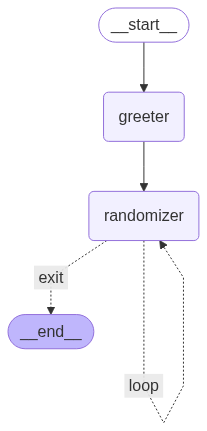

In [10]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
init_state = AgentState(
    name="Alice",
    numbers=[],
    counter=0
)

result = app.invoke(init_state)
print(result)

ENTERING LOOP: 1
ENTERING LOOP: 2
ENTERING LOOP: 3
ENTERING LOOP: 4
{'name': 'Hi there, Alice', 'numbers': [2, 7, 0, 9, 3], 'counter': 5}


# Exercise
Higher or lower game

In [53]:
class GameState(TypedDict):
    player_name: str
    guesses: List[int]
    target: int
    attempts: int
    lower_bound: int
    upper_bound: int
    output: str


def setup_node(state: GameState) -> GameState:
    """
    This node sets up the game
    """
    print(f"Hi {state["player_name"]},  Welcome to the Number Guessing Game!")
    state["attempts"] = 0
    state["lower_bound"] = 1
    state["upper_bound"] = 20
    state["target"] = random.randint(state["lower_bound"], state["upper_bound"])
    state["guesses"] = []
    state["output"] = ""
    return state

def guess_number_node(state: GameState) -> GameState:
    """
    This node will guess the number
    """
    state["attempts"] += 1
    guessed_number = random.randint(state["lower_bound"], state["upper_bound"])
    state["guesses"].append(guessed_number)
    return state

def hint_node(state: GameState) -> GameState:
    """
    This node gives a hint based on the guess
    """
    guessed_number = state["guesses"][-1]
    target = state["target"]

    if guessed_number < target:
        state["output"] = f"Your guess {guessed_number} is too low!"
        state["lower_bound"] = guessed_number + 1
        print(state["output"])

    elif guessed_number > target:
        state["output"] = f"Your guess {guessed_number} is too high!"
        state["upper_bound"] = guessed_number - 1
        print(state["output"])

    else:
        state["output"] = f"Congratulations {state['player_name']}! You guessed the number {target} in {state['attempts']} attempts!"
        print(state["output"])

    return state

def to_continue_game(state: GameState) -> GameState:
    """
    Function to decide what to do next in the game
    """
    guessed_number = state["guesses"][-1]
    target = state["target"]

    if guessed_number == target:
        return "exit"

    else:
        if state["attempts"] >= 7:
            state["output"] = f"Sorry {state['player_name']}, you've used all your attempts! The number was {target}."
            print(state["output"])
            return "exit"
        else:
            print(f"Continuing the game... {state["attempts"]} / 7 attempts")
            return "loop"
    

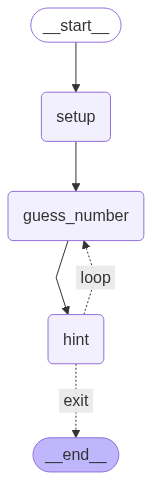

In [54]:
game_graph = StateGraph(GameState)

game_graph.add_node("setup", setup_node)
game_graph.add_node("guess_number", guess_number_node)
game_graph.add_node("hint", hint_node)

game_graph.add_edge(START, "setup")
game_graph.add_edge("setup", "guess_number")
game_graph.add_edge("guess_number", "hint")


game_graph.add_conditional_edges(
    "hint",
    to_continue_game,
    {
        "loop": "guess_number",
        "exit": END
    }
)
game_app = game_graph.compile()

from IPython.display import Image, display
display(Image(game_app.get_graph().draw_mermaid_png()))

In [55]:
game_start_state = GameState(
    player_name="Alice",
    guesses=[],
    attempts=0,
    lower_bound=1,
    upper_bound=20,
)

In [104]:
game_result = game_app.invoke(game_start_state)
print(game_result)

Hi Alice,  Welcome to the Number Guessing Game!
Your guess 2 is too low!
Continuing the game... 1 / 7 attempts
Your guess 15 is too high!
Continuing the game... 2 / 7 attempts
Your guess 5 is too low!
Continuing the game... 3 / 7 attempts
Your guess 14 is too high!
Continuing the game... 4 / 7 attempts
Your guess 6 is too low!
Continuing the game... 5 / 7 attempts
Your guess 7 is too low!
Continuing the game... 6 / 7 attempts
Your guess 12 is too high!
Sorry Alice, you've used all your attempts! The number was 8.
{'player_name': 'Alice', 'guesses': [2, 15, 5, 14, 6, 7, 12], 'target': 8, 'attempts': 7, 'lower_bound': 8, 'upper_bound': 11, 'output': 'Your guess 12 is too high!'}
